<a href="https://colab.research.google.com/github/adithi20/-CSE_Projects/blob/main/LSTM_BP_AR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving LSTM_BP_Data.xlsx to LSTM_BP_Data (3).xlsx
Available columns: Index(['DATE', 'SERIAL NUMBER', 'TIME', 'SYSTOLE', 'DIASTOLE'], dtype='object')
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 89s 91ms/step - loss: 0.5546 - val_loss: 0.3987
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.4185 - val_loss: 0.2579
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2504 - val_loss: 0.0902
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0828 - val_loss: 0.0111
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0301 - val_loss: 0.0514
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0319 - val_loss: 0.0022
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0096 - val_loss: 0.0095
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0199 - val_loss: 0.0046
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0096 - val_loss: 0.0037
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0064 - val_loss: 0.0089
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0085 - val_loss: 0.0041
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0052 - val_loss: 0.0024
Epoch 13/20

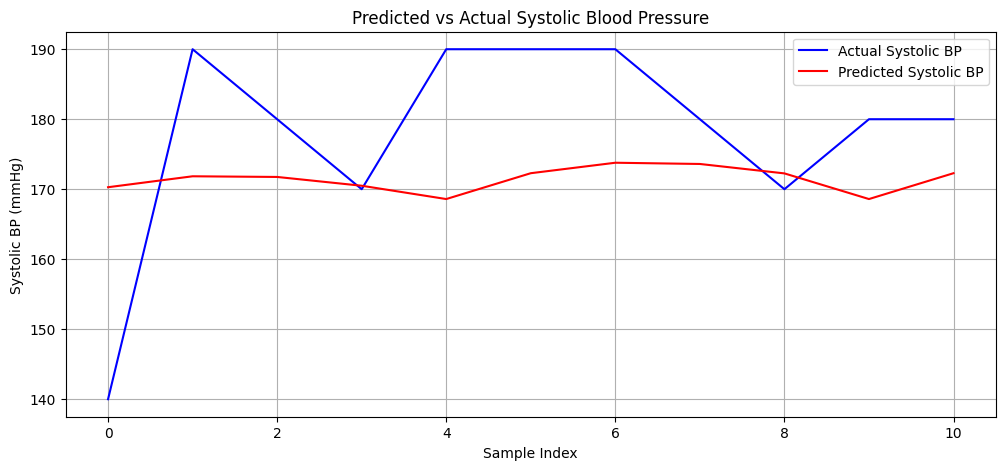

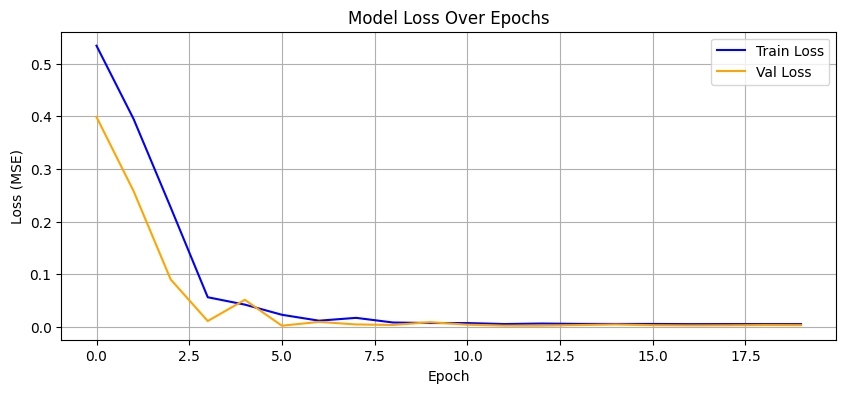

RMSE: 15.33 mmHg


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Step 1: Install & import necessary libraries
!pip install -q openpyxl

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from google.colab import files

# Step 2: Upload the file
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# Step 3: Load the Excel file
df = pd.read_excel(filename)
print("Available columns:", df.columns)

# Step 4: Normalize systolic BP
df['SYSTOLE_NORM'] = df['SYSTOLE'] / 220.0

# Step 5: ECG-style sampling using impulse train
impulse_interval = 5
df['Impulse'] = 0
df.loc[::impulse_interval, 'Impulse'] = 1
df['Sampled'] = df['SYSTOLE_NORM'] * df['Impulse']
df['Sampled'] = df['Sampled'].fillna(0)

# Step 6: Create LSTM sequences
window_size = 10
X, Y = [], []

signal = df['Sampled'].values
label = df['SYSTOLE_NORM'].values

for i in range(len(signal) - window_size):
    X.append(signal[i:i+window_size])
    Y.append(label[i+window_size])

X = np.array(X)
Y = np.array(Y)

# Reshape for LSTM input: (samples, time_steps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Step 7: Split into train/test/val sets (80/10/10 for small datasets)
train_size = int(len(X) * 0.8)
val_size = int(len(X) * 0.1)

X_train, Y_train = X[:train_size], Y[:train_size]
X_val, Y_val = X[train_size:train_size+val_size], Y[train_size:train_size+val_size]
X_test, Y_test = X[train_size+val_size:], Y[train_size+val_size:]

# Step 8: Define and train LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(window_size, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=20, batch_size=16)

# Step 9: Predict and evaluate
Y_pred = model.predict(X_test).flatten()

# Convert back to actual values
Y_pred_actual = Y_pred * 220
Y_test_actual = Y_test * 220

# Plot predicted vs actual
plt.figure(figsize=(12, 5))
plt.plot(Y_test_actual, label='Actual Systolic BP', color='blue')
plt.plot(Y_pred_actual, label='Predicted Systolic BP', color='red')
plt.title('Predicted vs Actual Systolic Blood Pressure')
plt.xlabel('Sample Index')
plt.ylabel('Systolic BP (mmHg)')
plt.legend()
plt.grid(True)
plt.show()

# Plot training/validation loss
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Val Loss', color='orange')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# Step 10: RMSE
rmse = np.sqrt(mean_squared_error(Y_test_actual, Y_pred_actual))
print(f'RMSE: {rmse:.2f} mmHg')

# Step 11: Save predictions to Excel
results_df = pd.DataFrame({
    'Actual Systolic BP': Y_test_actual,
    'Predicted Systolic BP': Y_pred_actual
})
results_df.to_excel('LSTM_BP_Predictions.xlsx', index=False)
files.download('LSTM_BP_Predictions.xlsx')


Saving LSTM_BP_Data.xlsx to LSTM_BP_Data (6).xlsx
Available columns: Index(['DATE', 'SERIAL NUMBER', 'TIME', 'SYSTOLE', 'DIASTOLE'], dtype='object')
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - loss: 0.6273 - val_loss: 0.4670
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.5011 - val_loss: 0.3375
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.3577 - val_loss: 0.1793
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1746 - val_loss: 0.0186
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0246 - val_loss: 0.0800
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0658 - val_loss: 0.0145
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0113 - val_loss: 0.0071
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0222 - val_loss: 0.0091
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0168 - val_loss: 0.0026
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0083 - val_loss: 0.0094
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0108 - val_loss: 0.0091
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0095 - val_loss: 0.0029
Epoch 13/20

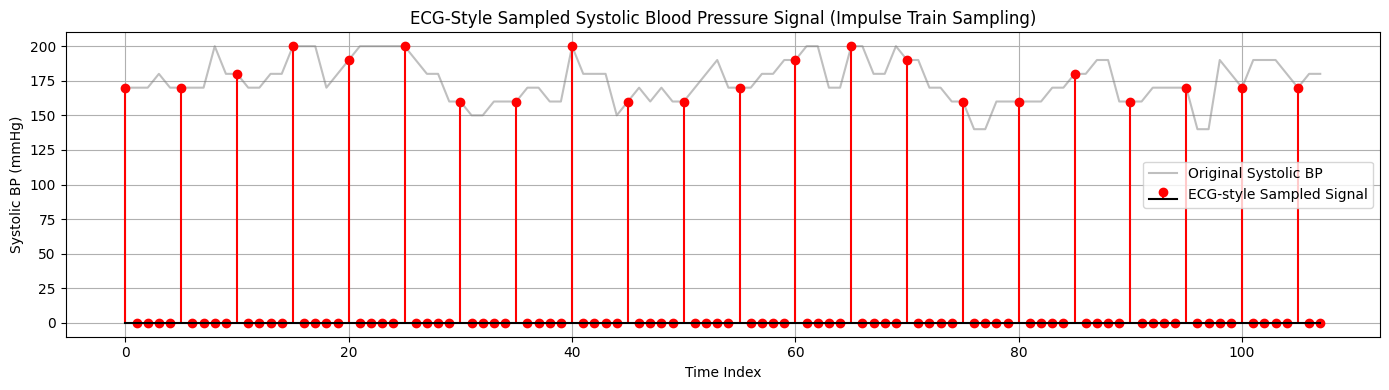

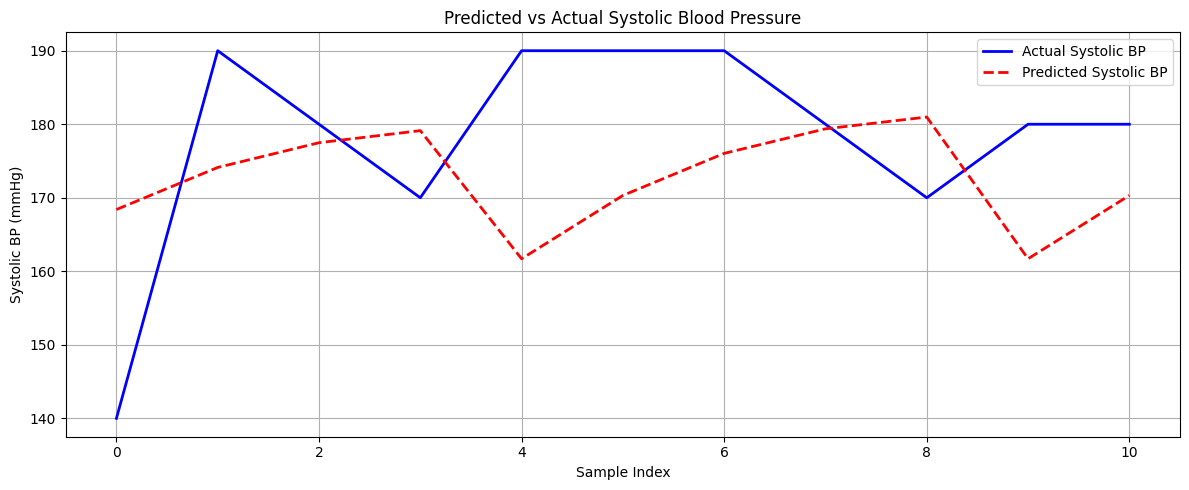

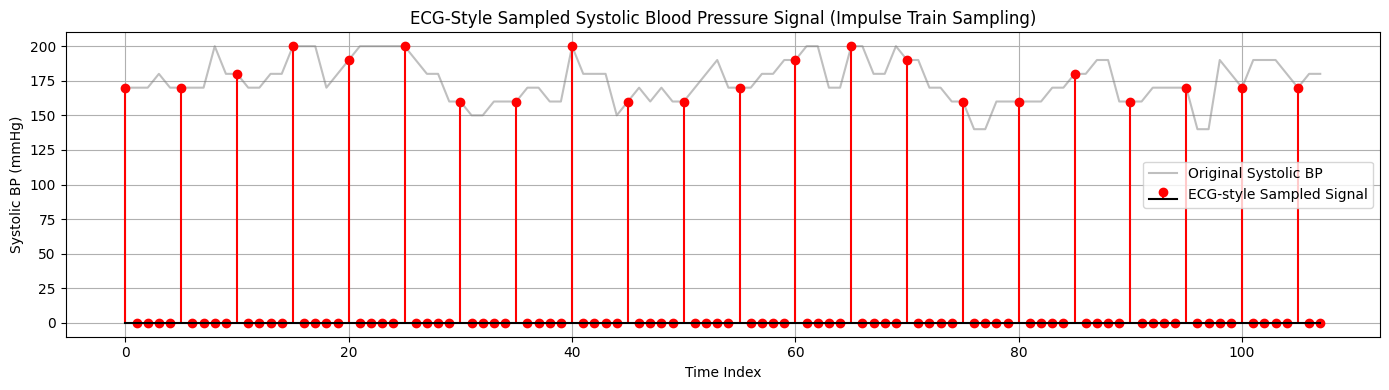

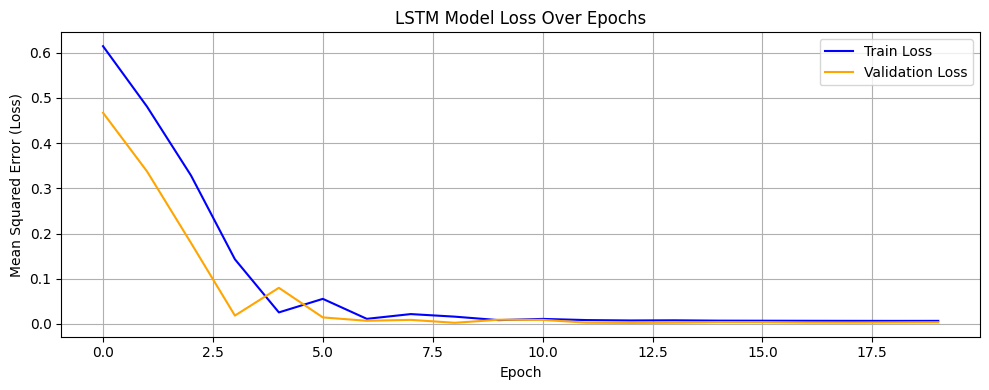

RMSE: 16.74 mmHg


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
# Step 1: Install & import necessary libraries
!pip install -q openpyxl

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from google.colab import files

# Step 2: Upload the file
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# Step 3: Load the Excel file
df = pd.read_excel(filename)
print("Available columns:", df.columns)

# Step 4: Normalize systolic BP
df['SYSTOLE_NORM'] = df['SYSTOLE'] / 220.0

# Step 5: ECG-style sampling using impulse train
impulse_interval = 5
df['Impulse'] = 0
df.loc[::impulse_interval, 'Impulse'] = 1
df['Sampled'] = df['SYSTOLE_NORM'] * df['Impulse']
df['Sampled'] = df['Sampled'].fillna(0)

# Step 6: Create LSTM sequences
window_size = 10
X, Y = [], []

signal = df['Sampled'].values
label = df['SYSTOLE_NORM'].values

for i in range(len(signal) - window_size):
    X.append(signal[i:i+window_size])
    Y.append(label[i+window_size])

X = np.array(X)
Y = np.array(Y)

# Reshape for LSTM input: (samples, time_steps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Step 7: Split into train/test/val sets (80/10/10 for small datasets)
train_size = int(len(X) * 0.8)
val_size = int(len(X) * 0.1)

X_train, Y_train = X[:train_size], Y[:train_size]
X_val, Y_val = X[train_size:train_size+val_size], Y[train_size:train_size+val_size]
X_test, Y_test = X[train_size+val_size:], Y[train_size+val_size:]

# Step 8: Define and train LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(window_size, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=20, batch_size=16)

# Step 9: Predict and evaluate
Y_pred = model.predict(X_test).flatten()
Y_pred_actual = Y_pred * 220
Y_test_actual = Y_test * 220

# ---------- New Diagram 1: ECG-Style Sampled Signal ----------
plt.figure(figsize=(14, 4))
plt.plot(df.index, df['SYSTOLE'], label='Original Systolic BP', alpha=0.5, color='gray')
plt.stem(df.index, df['Sampled'] * 220, linefmt='r-', markerfmt='ro', basefmt='k-', label='ECG-style Sampled Signal')

plt.title('ECG-Style Sampled Systolic Blood Pressure Signal (Impulse Train Sampling)')
plt.xlabel('Time Index')
plt.ylabel('Systolic BP (mmHg)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------- New Diagram 2: Predicted vs Actual (as before, enhanced) ----------
plt.figure(figsize=(12, 5))
plt.plot(Y_test_actual, label='Actual Systolic BP', color='blue', linewidth=2)
plt.plot(Y_pred_actual, label='Predicted Systolic BP', color='red', linestyle='--', linewidth=2)
plt.title('Predicted vs Actual Systolic Blood Pressure')
plt.xlabel('Sample Index')
plt.ylabel('Systolic BP (mmHg)')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------- New Diagram 3: Overlay ECG Signal vs LSTM Prediction ----------
plt.figure(figsize=(14, 4))
plt.plot(df.index, df['SYSTOLE'], label='Original Systolic BP', alpha=0.5, color='gray')
plt.stem(df.index, df['Sampled'] * 220, linefmt='r-', markerfmt='ro', basefmt='k-', label='ECG-style Sampled Signal')
plt.title('ECG-Style Sampled Systolic Blood Pressure Signal (Impulse Train Sampling)')
plt.xlabel('Time Index')
plt.ylabel('Systolic BP (mmHg)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# ---------- Existing: Plot training/validation loss ----------
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('LSTM Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (Loss)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 10: RMSE
rmse = np.sqrt(mean_squared_error(Y_test_actual, Y_pred_actual))
print(f'RMSE: {rmse:.2f} mmHg')

# Step 11: Save predictions to Excel
results_df = pd.DataFrame({
    'Actual Systolic BP': Y_test_actual,
    'Predicted Systolic BP': Y_pred_actual
})
results_df.to_excel('LSTM_BP_Predictions.xlsx', index=False)
files.download('LSTM_BP_Predictions.xlsx')